In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy.stats import multivariate_normal, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')
plt.rcParams['axes.facecolor'] = '#fafafa'

from utils.shift import inverse_train_test_procedure
from utils.vis import (plot_performance_scatter, 
                       plot_repr_uncertainty, 
                       METHYLCLOCK_NAMES_MAPPER,
                       plot_covariate_panel)

%load_ext autoreload
%autoreload 2

#aux
clock = pd.read_pickle('subdata/clock_coefs_mouse.pkl')['Petkovich']

# Rationale behind analysis

To decrease batch-effect:
- We will use Petkovich WT mice for training and validation (175 samples in total);
- We will use Petkovich WT + CR mice for testing caloric restriction effect on epigenetic age;
- Thompson contains only 50 blood samples and will be excluded to decrease batch effect;
- Meer does not contain blood samples and will be excluded to decrease confounding effect;
Working with files
- We downloaded processed data from Petkovich et al. from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE80672).
- We used both available strains B6D2F1 and C57BL/6 for training and testing



# Split dataset of Petkovich

In [2]:
df = pd.read_pickle('data/GSE80672/GSE80672_proc.pkl').T
met = pd.read_csv('data/GSE80672/GSE80672_metadata_proc.csv', index_col=0)
df = df/100.
met = met[(met['Condition'] == 'Wild Type') & (met['Tissue'] == 'Whole Blood')]

In [3]:
#Petkovich mice
aidx = met[met['Diet'] == 'standard'].index
dfa = df.loc[aidx]
meta = met.loc[aidx]

#CR mice
ridx = met[met['Diet'] == 'Calorie Restricted'].index
dfr = df.loc[ridx]
metr = met.loc[ridx]

print('Age, N sites', len(dfa.columns))
print('Rep, N sites', len(dfr.columns)) 
#low number of sites are accessible for in vivo reprogramming
#due to the poor intersection of samples with each other
#nevertheless, below we show that intersected sites are enough for clock construction

Age, N sites 1976089
Rep, N sites 1976089


## Check covariate shift

In [4]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

#conduct PCA on joined dataset
pca = PCA(2)
pca.fit(pd.concat([Xa_clock, Xr_clock]))
Xpa = pca.transform(Xa_clock)
Xpr = pca.transform(Xr_clock)

cond = metr['Condition'] == 'Old OSKM liver'
Xpr_control = Xpr[~cond]
Xpr_reprog = Xpr[cond]
yr_control = yr[~cond]
yr_reprog = yr[cond]

pvar = np.round(pca.explained_variance_ratio_, 2)

90 common sites


94.44% of sites are not rejected by KS test


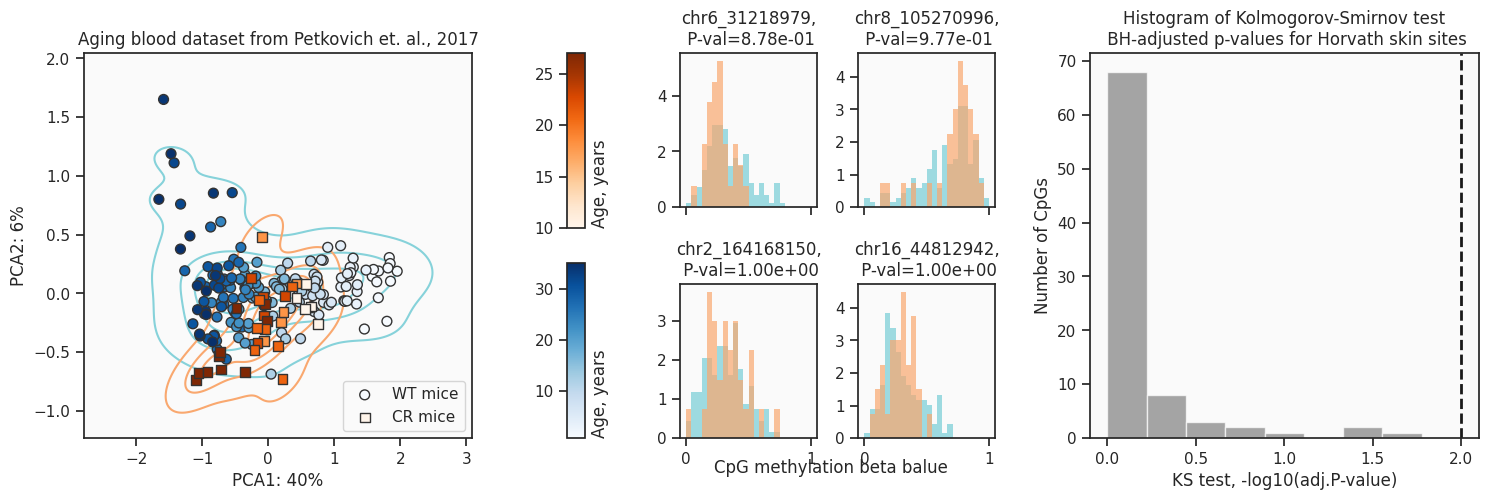

In [5]:
plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'Oranges',
                        color_train = '#86d2da',
                        color_test = '#f9a86f',
                        xa_thr=0.05,
                        xr_thr=0.05,
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Age, years',
                        legend_label_train = 'WT mice',
                        legend_label_test = 'CR mice',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Horvath skin sites',
                        pca_title = 'Aging blood dataset from Petkovich et. al., 2017',
                        pca_legend_pos = 'lower right',
                        # pca_xlim = [-1, 1.0],
                        # pca_ylim = [-1, 1.0] 
                        custom_bins=np.linspace(0, 2, 10))

plt.savefig('figs/review/re_aging_blood_mice_cr.pdf', format='pdf', bbox_inches='tight')
plt.show()

90 common sites
R2 train = 0.9921602078390053
R2 test = 0.9272627501528139
MAE train = 0.7597473108457253
MAE test = 2.1079424189507914
------------------------------
Resulting kernel: 11.4**2 * RBF(length_scale=3.35) + WhiteKernel(noise_level=2.32)
Resulting kernel (full): 11.2**2 * RBF(length_scale=3.58) + WhiteKernel(noise_level=3.02)


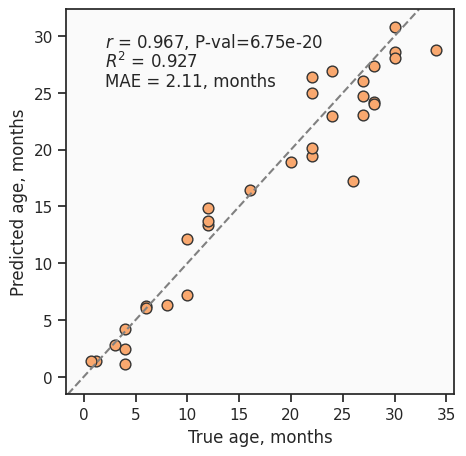

In [10]:
sites = clock.index.intersection(dfr.columns).intersection(dfa.columns)
print(f"{len(sites)} common sites")

Xa_clock = dfa[sites]
Xr_clock = dfr[sites]

ya = meta['Age']
yr = metr['Age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.20, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='months')
plt.savefig('figs/review/GP_blood_mice_test_performance.pdf', format='pdf', bbox_inches='tight')

# Refit on full data.
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(Xa_clock, ya)
print("Resulting kernel (full):", model.kernel_)

In [12]:
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr_ = metr.copy()
# metr_ = meta.loc[X_test.index]
metr_['gpr_age'] = y_test_predict_r
metr_['gpr_std'] = y_test_std_r
metr_['gpr_delta'] = metr_['gpr_age'] - metr_['Age']

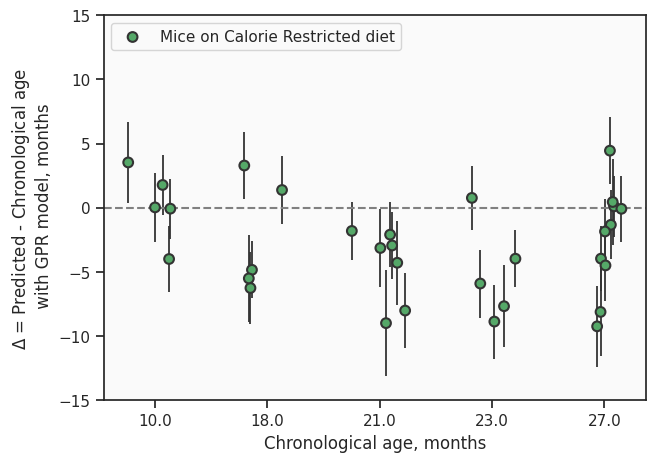

r test = 0.7874449007441187
R2 test = 0.2934557185979645
MAE test = 3.8499128082854677


In [13]:

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
np.random.seed(10) #fix random seed for stripplot
strip = sns.stripplot(data=metr_, 
                x='Age', 
                y='gpr_delta', 
				color='g',
                # palette='Set2',
                jitter=0.25,
                s=7, linewidth=1.5, edgecolor="#333333",
                ax=ax)
ax.set_xlabel('')
# ax.set_xticklabels(['CR'])

for age_group, coll in zip(sorted(metr_['Age'].unique()), strip.collections):
	coords = coll.get_offsets().data
	ax.errorbar(y=coords[:, 1], 
				x=coords[:, 0], 
				yerr=metr_['gpr_std'][metr_['Age'] == age_group], 
				linewidth=0, elinewidth=1.3, color='#333333')


plt.axhline(0, ls='--', color='grey')
ax.set_ylabel('$\Delta$ = Predicted - Chronological age \n with GPR model, months')
ax.set_xlabel('Chronological age, months')
ax.legend(['Mice on Calorie Restricted diet'], loc='upper left')
ax.set_ylim([-15, 15])

plt.savefig('figs/review/CR_CI.pdf', format='pdf', bbox_inches='tight')
plt.show()

print(f'r test = {np.corrcoef(yr, y_test_predict_r)[0,1]}')
print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')

In [14]:
for age_group in sorted(metr_['Age'].unique()):
	sub = metr_[metr_['Age'] == age_group]

	from pymare import meta_regression
	meta_df_ = meta_regression(
					sub['gpr_delta'].values, 
					sub['gpr_std'].values**2, 
					# X_names=['CR'], 
					add_intercept=True, 
					method='REML').to_df().set_index('name')
	pval = meta_df_.loc['intercept', 'p-value']
	print(f'P-value of rejuvenation effect is {pval} for {age_group} age group.')
	meta_df_

P-value of rejuvenation effect is 0.9540590308500017 for 10.0 age group.
P-value of rejuvenation effect is 0.24764947676593918 for 18.0 age group.
P-value of rejuvenation effect is 0.0003888145810514443 for 21.0 age group.
P-value of rejuvenation effect is 0.004167107651386059 for 23.0 age group.
P-value of rejuvenation effect is 0.08103601019734652 for 27.0 age group.


In [15]:
sub = metr_.copy()

from pymare import meta_regression
meta_df_ = meta_regression(
				sub['gpr_delta'].values, 
				sub['gpr_std'].values**2, 
				# X_names=['CR'], 
				add_intercept=True, 
				method='REML').to_df().set_index('name')
pval = meta_df_.loc['intercept', 'p-value']
print(f'P-value of rejuvenation effect is {pval} for all ages.')
meta_df_

P-value of rejuvenation effect is 5.563880710501845e-05 for all ages.


,estimate,se,z-score,p-value,ci_0.025,ci_0.975
name,,,,,,
intercept,-2.604233,0.646118,-4.030582,0.000056,-3.870601,-1.337864
